Подключаем необходимые библиотеки

In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import random
import pylab
import numpy.distutils.system_info as sysinfo
import scipy.special
from random import randrange
import math
import sys

Реализация необходимых функция для проведения базового эксперимента. Эксперимент ставится для логистической регресии. Ниже реализованы функции именно для этой базового эксперимента

# Эксперимент на a7a датасэте

## logistic regression problem

In [27]:
def f(x): 
    '''
     функция логистической регрессии для всех worker-ов в точке x
    '''
    ans = 0
    for i in range(N):
        ans += math.log(1+math.exp(-b[i]*A[i].dot(x)))/N
    ans += lmbd/2*np.linalg.norm(x)**2
    return ans

def Hessian(x, k, j): 
    '''
    функция для вычисления Гессиана в точке x для i-го workera на j-ой точке его датасэта
    '''
    i = k*m+j
    alpha = b[i]**2*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))**2
    ans = lmbd*np.eye(d) + alpha*A[i].reshape((d,1)).dot(A[i].reshape(1,d))
    return ans

def coef_computation(x, k, j): 
    '''
    функция для вычисления коэффициента, 
    который стоит перед одноранговой матрицей Гессе для i-го worker-а на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = b[i]**2*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))**2
    return alpha

def gradient(x, k, j): 
    '''
    вычисление градиента для i-го worker-а на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = -b[i]*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))
    ans = lmbd*x+alpha*A[i]
    return ans

def coef_comp(x, k, j):
    '''
    вычисление коэффициента, 
    который стоит перед градиентом для i-го worker-a 
    на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = -b[i]*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))
    return alpha

Далее идет считывание данных из датасэта a7a. Для успешного запуска данной ячейки нужно наличие файла `a7a.txt` из репозитория с кодом в той же папке, что текущий ноутбук.

In [28]:
N = 16100            # полное число точек в датасэте
n = 100              # число worker-ов
m = 161              # размер датасэта каждого worker-а
d = 123              # количество признаков (оно же размерность вектора параметра Лог.Регрессии)
lmbd = 0.1           # коэффициент при l_2 регуляризаторе
mu = lmbd            # коэффициент при l_2 регуляризаторе

b = np.zeros((N,))   # вектор меток
A = np.zeros((N, d)) # матрица объект-признак

fle = open('a7a.txt', 'r')
for i, line in enumerate(fle):
    line = line.split()
    for c in line:
        if c == '+1':
            b[i] = 1
        elif c == '-1':
            b[i] = -1
        elif c == '\n':
            continue
        else:
            c = c.split(':')
            A[i][int(c[0]) - 1] = float(c[1])     

Вычисляем константу липшица функциии в задаче Лог.Рег.

In [29]:
L = 1/4*np.linalg.norm(A, 2)**2 
L

25322.463187067755

Вычисление биномиальных коэффициентов, которые понадобятся для расчета количества бит, которые нужно для отправить на мастер-node

In [30]:
binom = np.zeros((d+1, d+1))
for i in range(d+1):
    binom[i,0] = 1
    binom[i,i] = 1
for i in range(2,d+1):
    for j in range(1, i):
        binom[i,j] = binom[i-1,j]+binom[i-1,j-1]

Реализация метода Ньютона

In [53]:
stand_nm = [] # массив для запоминания значений функции в методе Ньютона

y = np.ones(d)*0.1 # начальное приближение для оптимальной точки

In [54]:
n_of_steps = 10 # количество шагов оптимизации
for n_step in range(n_of_steps):
    value_stand_nm = f(y) 
    print('St. NM:', value_stand_nm)
    
    # далее идет реализация метода Ньютона
    stand_nm.append(value_stand_nm)
    true_hessian = np.zeros((d,d))
    g = np.zeros(d)
    for k in range(n):
        for j in range(m):
            true_hessian += Hessian(y, k, j)/N
            g += gradient(y, k, j)/N
    y = y - np.linalg.inv(true_hessian).dot(g) 

St. NM: 0.6933714452027318
St. NM: 0.6908180732199471
St. NM: 0.6908180289853603
St. NM: 0.6908180289853579
St. NM: 0.690818028985358
St. NM: 0.6908180289853579
St. NM: 0.6908180289853579
St. NM: 0.690818028985358
St. NM: 0.690818028985358
St. NM: 0.6908180289853579


In [33]:
x_star = y # решение при помощи метода Ньютона, используем его в качестве эталона
f_optimal = f(x_star) # выведем значение в оптимуме
f_optimal

0.4719062470490377

In [34]:
max_coef_newton = [] # массив для запоминания значений функции в базовом методе MCNM
max_coef_scaled = [] # массив для запоминания значений функции в модифицированном алгоритме SMCNM
rand_gd = []         # массив для запоминания значений функции в SGD
stand_gd = []        # массив для запоминания значений функции в стандартном GD



scaled_max_coef = [] # массив для запоминания количества отправленных бит на каждом шаге SMCNM
bits_max_coef = []   # массив для запоминания количества отправленных бит на каждом шаге MCNM
bits_rand_gd = []    # массив для запоминания количества отправленных бит на каждом шаге SGD
cur_bits_max_coef = 0 # полное число отправленных бит в MCNM
cur_bits_rand_gd = 0  # полное число отправленных бит в SGD
cur_bits_scaled = 0   # полное число отправленных бит в SMCNM

# начальные точки каждого из алгоритмов
x = np.ones(d)*0.1 # MCNM
z = x              # SMCNM
t = x              # SGD
q=x                # GD


n_of_steps = 20 # количество шагов для каждого из алгоритма
for n_step in range(n_of_steps):
    value = f(q)
    value_max_coef = f(x)
    value_stand_nm = f(y) 
    value_rand_gd = f(z)
    value_stand_gd = f(t)
    print('Scaled Max Coef:', value, 'MaxCoef', value_max_coef, 'Rnd.GD', value_rand_gd, 'St.GD:', value_stand_gd)
    
    # реализация SMCNM
    max_coef_scaled.append(value)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(q, k, j)/coef_computation(x_star, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(q, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*coef_computation(x_star, k, j)*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_scaled += 64*n
    q = q - np.linalg.inv(B).dot(g)
    scaled_max_coef.append(cur_bits_scaled)


    # реализация MCNM
    max_coef_newton.append(value_max_coef)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(x, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(x, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_max_coef += 64*n
    x = x - np.linalg.inv(B).dot(g)
    bits_max_coef.append(cur_bits_max_coef)

    
    # реализация SGD
    rand_gd.append(value_rand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        j = np.random.choice(m)
        g_global += gradient(z, k, j)/n
    cur_bits_rand_gd += 64*n
    bits_rand_gd.append(cur_bits_rand_gd)
    z = z - 1/L*g_global
    
    # реализация GD
    stand_gd.append(value_stand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        for j in range(m):
            g_global += gradient(t, k, j)/N
    t = t - 1/L*g_global

Scaled Max Coef: 1.332540211834643 MaxCoef 1.332540211834643 Rnd.GD 1.332540211834643 St.GD: 1.332540211834643
Scaled Max Coef: 0.5607770136413298 MaxCoef 0.4869507591544093 Rnd.GD 1.3324582627326653 St.GD: 1.3324566701139249
Scaled Max Coef: 0.48502537437944193 MaxCoef 0.4738602407701045 Rnd.GD 1.3323743260964966 St.GD: 1.3323731354975703
Scaled Max Coef: 0.4721999165295767 MaxCoef 0.47228904790280163 Rnd.GD 1.3322920220452763 St.GD: 1.3322896079857471
Scaled Max Coef: 0.47190638756568476 MaxCoef 0.4719823186487655 Rnd.GD 1.3321979027210853 St.GD: 1.3322060875783657
Scaled Max Coef: 0.47190624704907064 MaxCoef 0.47192109262759246 Rnd.GD 1.3321054506550305 St.GD: 1.3321225742753853
Scaled Max Coef: 0.4719062470490382 MaxCoef 0.4719091109691352 Rnd.GD 1.3320206567461792 St.GD: 1.3320390680767573
Scaled Max Coef: 0.4719062470490376 MaxCoef 0.47190679632831845 Rnd.GD 1.331935003127604 St.GD: 1.3319555689823999
Scaled Max Coef: 0.4719062470490376 MaxCoef 0.4719063521083021 Rnd.GD 1.3318604

Далее делаем сдвиг значений функций относительно оптимума для построения графика

In [35]:
max_coef_scaled = np.array(max_coef_scaled) - f_optimal
stand_gd = np.array(stand_gd) - f_optimal
max_coef_newton = np.array(max_coef_newton) - f_optimal
stand_nm = np.array(stand_nm) - f_optimal
rand_gd = np.array(rand_gd) - f_optimal

Далее идет ячейка для построения графика, показывающего результаты оптимизации

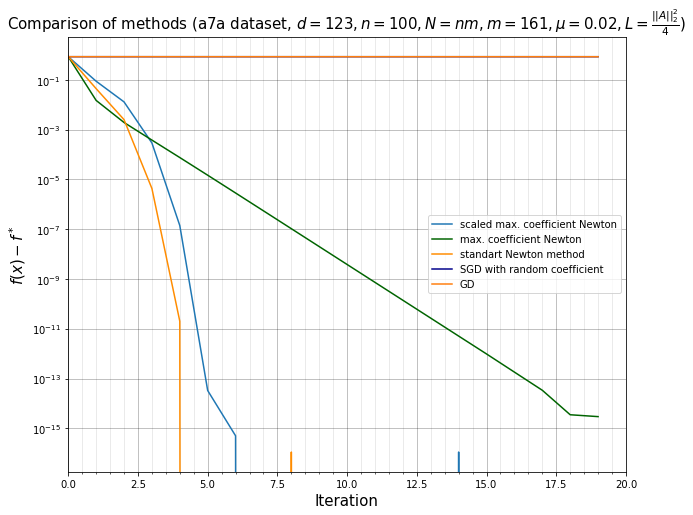

In [36]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12.png')
plt.show()

График, который иллюстрирует сравнение алгоритмов в терминах колисетсва инфмомации

In [37]:
L = 161*mu # используем оценочное значение константы Липшица для более эффективной работы методов первого порядка

Дальнейший код повторяет предыдущие, но с измененным параметром константы липшица, поэтому не нуждается в детальном комментировании

In [38]:
stand_nm = [] # массив для запоминания значений функции в методе Ньютона

y = np.ones(d)*0.1 # начальное приближение для оптимальной точки

n_of_steps = 10 # количество шагов оптимизации
for n_step in range(n_of_steps):
    value_stand_nm = f(y) 
    print('St. NM:', value_stand_nm)
    
    # далее идет реализация метода Ньютона
    stand_nm.append(value_stand_nm)
    true_hessian = np.zeros((d,d))
    g = np.zeros(d)
    for k in range(n):
        for j in range(m):
            true_hessian += Hessian(y, k, j)/N
            g += gradient(y, k, j)/N
    y = y - np.linalg.inv(true_hessian).dot(g) 

x_star = y # решение при помощи метода Ньютона, используем его в качестве эталона
f(x_star) # выведем значение в оптимуме

max_coef_newton = [] # массив для запоминания значений функции в базовом методе MCNM
max_coef_scaled = [] # массив для запоминания значений функции в модифицированном алгоритме SMCNM
rand_gd = []         # массив для запоминания значений функции в SGD
stand_gd = []        # массив для запоминания значений функции в стандартном GD



scaled_max_coef = [] # массив для запоминания количества отправленных бит на каждом шаге SMCNM
bits_max_coef = []   # массив для запоминания количества отправленных бит на каждом шаге MCNM
bits_rand_gd = []    # массив для запоминания количества отправленных бит на каждом шаге SGD
cur_bits_max_coef = 0 # полное число отправленных бит в MCNM
cur_bits_rand_gd = 0  # полное число отправленных бит в SGD
cur_bits_scaled = 0   # полное число отправленных бит в SMCNM

# начальные точки каждого из алгоритмов
x = np.ones(d)*0.1 # MCNM
z = x              # SMCNM
t = x              # SGD
q=x                # GD


n_of_steps = 20 # количество шагов для каждого из алгоритма
for n_step in range(n_of_steps):
    value = f(q)
    value_max_coef = f(x)
    value_stand_nm = f(y) 
    value_rand_gd = f(z)
    value_stand_gd = f(t)
    print('Scaled Max Coef:', value, 'MaxCoef', value_max_coef, 'Rnd.GD', value_rand_gd, 'St.GD:', value_stand_gd)
    
    # реализация SMCNM
    max_coef_scaled.append(value)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(q, k, j)/coef_computation(x_star, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(q, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*coef_computation(x_star, k, j)*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_scaled += 64*n
    q = q - np.linalg.inv(B).dot(g)
    scaled_max_coef.append(cur_bits_scaled)


    # реализация MCNM
    max_coef_newton.append(value_max_coef)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(x, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(x, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_max_coef += 64*n
    x = x - np.linalg.inv(B).dot(g)
    bits_max_coef.append(cur_bits_max_coef)

    
    # реализация SGD
    rand_gd.append(value_rand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        j = np.random.choice(m)
        g_global += gradient(z, k, j)/n
    cur_bits_rand_gd += 64*n
    bits_rand_gd.append(cur_bits_rand_gd)
    z = z - 1/L*g_global
    
    # реализация GD
    stand_gd.append(value_stand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        for j in range(m):
            g_global += gradient(t, k, j)/N
    t = t - 1/L*g_global

St. NM: 1.332540211834643
St. NM: 0.5165721472121819
St. NM: 0.47444838829322666
St. NM: 0.47191058499184035
St. NM: 0.47190624706907425
St. NM: 0.4719062470490377
St. NM: 0.4719062470490374
St. NM: 0.4719062470490377
St. NM: 0.47190624704903783
St. NM: 0.4719062470490375
Scaled Max Coef: 1.332540211834643 MaxCoef 1.332540211834643 Rnd.GD 1.332540211834643 St.GD: 1.332540211834643
Scaled Max Coef: 0.5607770136413298 MaxCoef 0.4869507591544093 Rnd.GD 1.2261795794246537 St.GD: 1.2057166933552919
Scaled Max Coef: 0.48502537437944193 MaxCoef 0.4738602407701045 Rnd.GD 1.1196300237719512 St.GD: 1.0966971538533137
Scaled Max Coef: 0.4721999165295767 MaxCoef 0.47228904790280163 Rnd.GD 1.0201119485302157 St.GD: 1.0044554560982841
Scaled Max Coef: 0.47190638756568476 MaxCoef 0.4719823186487655 Rnd.GD 0.935572789097236 St.GD: 0.9274325338107977
Scaled Max Coef: 0.47190624704907064 MaxCoef 0.47192109262759246 Rnd.GD 0.8697118968382105 St.GD: 0.8637575433039475
Scaled Max Coef: 0.4719062470490382 M

In [40]:
max_coef_scaled = np.array(max_coef_scaled) - f_optimal
stand_gd = np.array(stand_gd) - f_optimal
max_coef_newton = np.array(max_coef_newton) - f_optimal
stand_nm = np.array(stand_nm) - f_optimal
rand_gd = np.array(rand_gd) - f_optimal

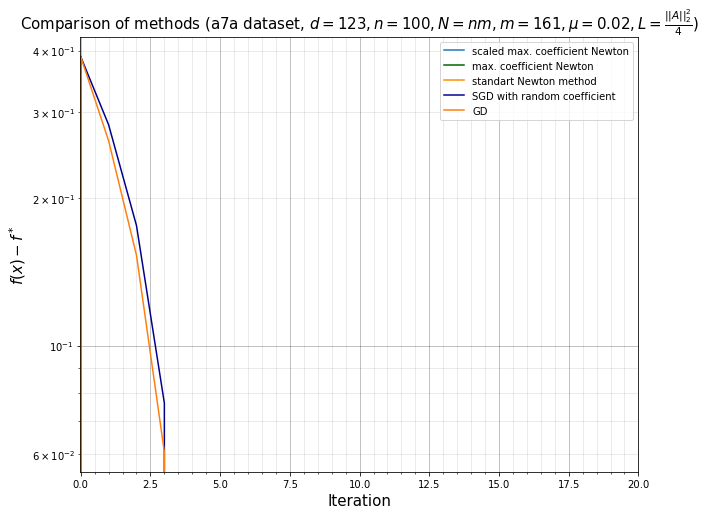

In [41]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12222.png')
plt.show()

Исследование размера локальной сходимости

In [42]:
# Нужно расскоментировать ту строку в зависимости от размера локальной области
 size = 0.15 # при таком размере рассходится метод Ньютона
# size = 0.25 # при таком размере расходится MCNM
# size = 0.32 # при таком методе расходится SMCNM

Далее используется тот же код, что и выше, поэтому в детальном комментировании не нуждается

In [43]:
stand_nm = [] # массив для запоминания значений функции в методе Ньютона

y = np.ones(d)*size # начальное приближение для оптимальной точки

n_of_steps = 10 # количество шагов оптимизации
for n_step in range(n_of_steps):
    value_stand_nm = f(y) 
    print('St. NM:', value_stand_nm)
    
    # далее идет реализация метода Ньютона
    stand_nm.append(value_stand_nm)
    true_hessian = np.zeros((d,d))
    g = np.zeros(d)
    for k in range(n):
        for j in range(m):
            true_hessian += Hessian(y, k, j)/N
            g += gradient(y, k, j)/N
    y = y - np.linalg.inv(true_hessian).dot(g) 

x_star = y # решение при помощи метода Ньютона, используем его в качестве эталона
f(x_star) # выведем значение в оптимуме

max_coef_newton = [] # массив для запоминания значений функции в базовом методе MCNM
max_coef_scaled = [] # массив для запоминания значений функции в модифицированном алгоритме SMCNM
rand_gd = []         # массив для запоминания значений функции в SGD
stand_gd = []        # массив для запоминания значений функции в стандартном GD



scaled_max_coef = [] # массив для запоминания количества отправленных бит на каждом шаге SMCNM
bits_max_coef = []   # массив для запоминания количества отправленных бит на каждом шаге MCNM
bits_rand_gd = []    # массив для запоминания количества отправленных бит на каждом шаге SGD
cur_bits_max_coef = 0 # полное число отправленных бит в MCNM
cur_bits_rand_gd = 0  # полное число отправленных бит в SGD
cur_bits_scaled = 0   # полное число отправленных бит в SMCNM

# начальные точки каждого из алгоритмов
x = np.ones(d)*size # MCNM
z = x              # SMCNM
t = x              # SGD
q = x              # GD


n_of_steps = 20 # количество шагов для каждого из алгоритма
for n_step in range(n_of_steps):
    value = f(q)
    value_max_coef = f(x)
    value_stand_nm = f(y) 
    value_rand_gd = f(z)
    value_stand_gd = f(t)
    print('Scaled Max Coef:', value, 'MaxCoef', value_max_coef, 'Rnd.GD', value_rand_gd, 'St.GD:', value_stand_gd)
    
    # реализация SMCNM
    max_coef_scaled.append(value)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(q, k, j)/coef_computation(x_star, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(q, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*coef_computation(x_star, k, j)*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_scaled += 64*n
    q = q - np.linalg.inv(B).dot(g)
    scaled_max_coef.append(cur_bits_scaled)


    # реализация MCNM
    max_coef_newton.append(value_max_coef)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(x, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(x, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_max_coef += 64*n
    x = x - np.linalg.inv(B).dot(g)
    bits_max_coef.append(cur_bits_max_coef)

    
    # реализация SGD
    rand_gd.append(value_rand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        j = np.random.choice(m)
        g_global += gradient(z, k, j)/n
    cur_bits_rand_gd += 64*n
    bits_rand_gd.append(cur_bits_rand_gd)
    z = z - 1/L*g_global
    
    # реализация GD
    stand_gd.append(value_stand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        for j in range(m):
            g_global += gradient(t, k, j)/N
    t = t - 1/L*g_global

St. NM: 1.8280822947372481
St. NM: 0.9018925356394063
St. NM: 1.673337885502781
St. NM: 1.1490487808467478
St. NM: 3.5046650515365223
St. NM: 7.141881696907303
St. NM: 13.125586100343815
St. NM: 28.859100459087934
St. NM: 13.149733851816574
St. NM: 28.859617134284576
Scaled Max Coef: 1.8280822947372481 MaxCoef 1.8280822947372481 Rnd.GD 1.8280822947372481 St.GD: 1.8280822947372481
Scaled Max Coef: 1.7765615567284767 MaxCoef 0.6540291295611282 Rnd.GD 1.650034630297868 St.GD: 1.6519247422427612
Scaled Max Coef: 1.7567681190014641 MaxCoef 0.5252876225010812 Rnd.GD 1.4861032083043342 St.GD: 1.492875317526593
Scaled Max Coef: 1.7404840962133252 MaxCoef 0.4877180175668655 Rnd.GD 1.3512477309883435 St.GD: 1.3518222829557667
Scaled Max Coef: 1.7265187644114284 MaxCoef 0.4760509698637675 Rnd.GD 1.232059190459554 St.GD: 1.228965255552696
Scaled Max Coef: 1.71427612299752 MaxCoef 0.4728563329954664 Rnd.GD 1.1287685148356792 St.GD: 1.1237597610046604
Scaled Max Coef: 1.703386760660611 MaxCoef 0.472

In [44]:
max_coef_scaled = np.array(max_coef_scaled) - f_optimal
stand_gd = np.array(stand_gd) - f_optimal
max_coef_newton = np.array(max_coef_newton) - f_optimal
stand_nm = np.array(stand_nm) - f_optimal
rand_gd = np.array(rand_gd) - f_optimal

Если был выбран size=0.15, то запустите ячейку ниже

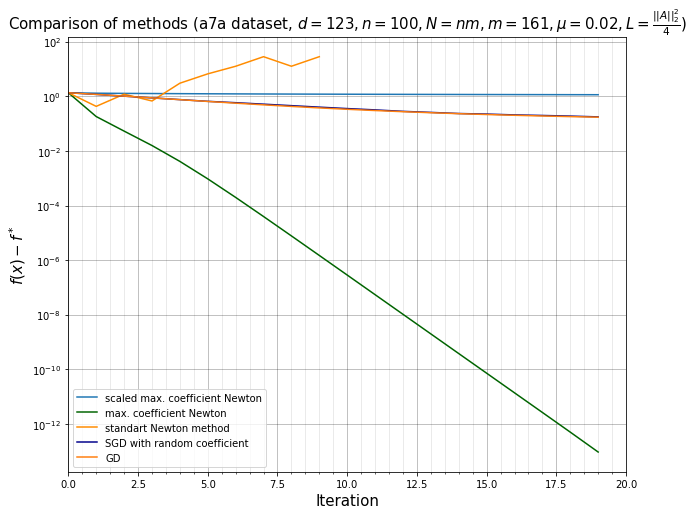

In [45]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12222.png')
plt.show()

Если был выбран size=0.25, запустите ячейку ниже

In [ ]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12222.png')
plt.show()

Если выбран size=0.32, запустите ячейку ниже

In [ ]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12222.png')
plt.show()

# Эксперимент на сгенерированном датасэте

## Logistic regression

Генерация выборки 

In [58]:
N = 16100            # полное число точек в датасэте
n = 100              # число worker-ов
m = 161              # размер датасэта каждого worker-а
d = 123              # количество признаков (оно же размерность вектора параметра Лог.Регрессии)
lmbd = 0.1           # коэффициент при l_2 регуляризаторе
mu = lmbd            # коэффициент при l_2 регуляризаторе

b = np.random.uniform(-1, 1, (N,)) # вектор меток
A = np.random.uniform(-0.1, 0.1, (N, d))# матрица объект-признак

mu = lmbd   

Вычисление констант функций, необходимых для GD и SGD

In [59]:
H = lmbd*np.eye(d)
x = np.ones(d)*150
for i in range(N):
    H += 1/N*(A[i].dot(x)-b[i])**2*A[i].reshape((d,1)).dot(A[i].reshape(1,d))
L =np.linalg.eig(H)[0].max()
mu = lmbd

In [60]:
def f(x): 
    '''
     функция логистической регрессии для всех worker-ов в точке x
    '''
    ans = 0
    for i in range(N):
        ans += math.log(1+math.exp(-b[i]*A[i].dot(x)))/N
    ans += lmbd/2*np.linalg.norm(x)**2
    return ans

def Hessian(x, k, j): 
    '''
    функция для вычисления Гессиана в точке x для i-го workera на j-ой точке его датасэта
    '''
    i = k*m+j
    alpha = b[i]**2*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))**2
    ans = lmbd*np.eye(d) + alpha*A[i].reshape((d,1)).dot(A[i].reshape(1,d))
    return ans

def coef_computation(x, k, j): 
    '''
    функция для вычисления коэффициента, 
    который стоит перед одноранговой матрицей Гессе для i-го worker-а на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = b[i]**2*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))**2
    return alpha

def gradient(x, k, j): 
    '''
    вычисление градиента для i-го worker-а на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = -b[i]*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))
    ans = lmbd*x+alpha*A[i]
    return ans

def coef_comp(x, k, j):
    '''
    вычисление коэффициента, 
    который стоит перед градиентом для i-го worker-a 
    на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = -b[i]*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))
    return alpha

Далее идет реализация метода Ньютона

In [67]:
stand_nm = [] # массив для запоминания значений функции в методе Ньютона

y = np.ones(d)*0.1 # начальное приближение для оптимальной точки

n_of_steps = 10 # количество шагов оптимизации
for n_step in range(n_of_steps):
    value_stand_nm = f(y) 
    print('St. NM:', value_stand_nm)
    
    # далее идет реализация метода Ньютона
    stand_nm.append(value_stand_nm)
    true_hessian = np.zeros((d,d))
    g = np.zeros(d)
    for k in range(n):
        for j in range(m):
            true_hessian += Hessian(y, k, j)/N
            g += gradient(y, k, j)/N
    y = y - np.linalg.inv(true_hessian).dot(g) 

St. NM: 0.7550082282351105
St. NM: 0.6931377843133939
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972
St. NM: 0.6931377843126972


In [68]:
y_star = y # решение при помощи метода Ньютона, используем его в качестве эталона
f_optimal = f(x_star) # выведем значение в оптимуме
f_optimal

0.6931377843126972

Далее идет реализация всех остальных методов

In [69]:
max_coef_newton = [] # массив для запоминания значений функции в базовом методе MCNM
max_coef_scaled = [] # массив для запоминания значений функции в модифицированном алгоритме SMCNM
rand_gd = []         # массив для запоминания значений функции в SGD
stand_gd = []        # массив для запоминания значений функции в стандартном GD



scaled_max_coef = [] # массив для запоминания количества отправленных бит на каждом шаге SMCNM
bits_max_coef = []   # массив для запоминания количества отправленных бит на каждом шаге MCNM
bits_rand_gd = []    # массив для запоминания количества отправленных бит на каждом шаге SGD
cur_bits_max_coef = 0 # полное число отправленных бит в MCNM
cur_bits_rand_gd = 0  # полное число отправленных бит в SGD
cur_bits_scaled = 0   # полное число отправленных бит в SMCNM

# начальные точки каждого из алгоритмов
x = np.ones(d)*0.1 # MCNM
z = x              # SMCNM
t = x              # SGD
q=x                # GD


n_of_steps = 20 # количество шагов для каждого из алгоритма
for n_step in range(n_of_steps):
    value = f(q)
    value_max_coef = f(x)
    value_stand_nm = f(y) 
    value_rand_gd = f(z)
    value_stand_gd = f(t)
    print('Scaled Max Coef:', value, 'MaxCoef', value_max_coef, \
          'St. NM:', value_stand_nm, 'Rnd.GD', value_rand_gd, 'St.GD:', value_stand_gd)
    
    # реализация SMCNM
    max_coef_scaled.append(value)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(q, k, j)/coef_computation(y_star, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(q, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*coef_computation(y_star, k, j)*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_scaled += 64*n
    q = q - np.linalg.inv(B).dot(g)
    scaled_max_coef.append(cur_bits_scaled)


    # реализация MCNM
    max_coef_newton.append(value_max_coef)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(x, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(x, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_max_coef += 64*n
    x = x - np.linalg.inv(B).dot(g)
    bits_max_coef.append(cur_bits_max_coef)
    
    # реализация SGD
    rand_gd.append(value_rand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        j = np.random.choice(m)
        g_global += gradient(z, k, j)/n
    cur_bits_rand_gd += 64*n
    bits_rand_gd.append(cur_bits_rand_gd)
    z = z - 1/L*g_global
    
    # реализация GD
    stand_gd.append(value_stand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        for j in range(m):
            g_global += gradient(t, k, j)/N
    t = t - 1/L*g_global

Scaled Max Coef: 0.7550082282351105 MaxCoef 0.7550082282351105 St. NM: 0.6931377843126972 Rnd.GD 0.7550082282351105 St.GD: 0.7550082282351105
Scaled Max Coef: 0.6931377843128717 MaxCoef 0.693139661323706 St. NM: 0.6931377843126972 Rnd.GD 0.7548756228448493 St.GD: 0.7548763801647334
Scaled Max Coef: 0.6931377843126972 MaxCoef 0.6931377843715801 St. NM: 0.6931377843126972 Rnd.GD 0.7547432380224292 St.GD: 0.75474481306652
Scaled Max Coef: 0.6931377843126972 MaxCoef 0.6931377843126993 St. NM: 0.6931377843126972 Rnd.GD 0.7546119644790567 St.GD: 0.7546135263417201
Scaled Max Coef: 0.6931377843126972 MaxCoef 0.6931377843127017 St. NM: 0.6931377843126972 Rnd.GD 0.7544791878934202 St.GD: 0.7544825193928517
Scaled Max Coef: 0.6931377843126972 MaxCoef 0.6931377843126968 St. NM: 0.6931377843126972 Rnd.GD 0.7543506906911684 St.GD: 0.7543517916237067
Scaled Max Coef: 0.6931377843126972 MaxCoef 0.6931377843126975 St. NM: 0.6931377843126972 Rnd.GD 0.7542219016707447 St.GD: 0.7542213424393431
Scaled Ma

Сдвиг значений функция относительн оптимального

In [70]:
max_coef_scaled = np.array(max_coef_scaled) - f_optimal
stand_gd = np.array(stand_gd) - f_optimal
max_coef_newton = np.array(max_coef_newton) - f_optimal
stand_nm = np.array(stand_nm) - f_optimal
rand_gd = np.array(rand_gd) - f_optimal

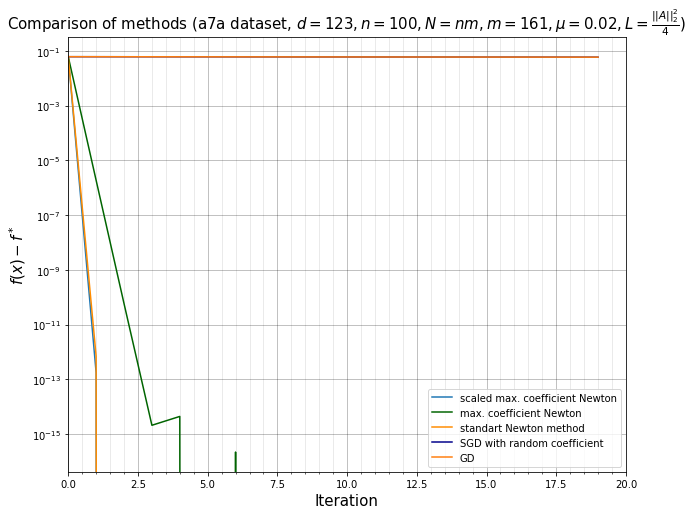

In [71]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12.png')
plt.show()

**Вывод:** данные эксперименты показывают, что придуманные алгоритмы второго порядка превосходят в работе методы первого порядка, что мотивирует для дальнейшей работы в этом направлении